In [1]:
import os
import sys
sys.path.insert(1, '../ELLA')
import joblib
from ELLA import ELLA
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
from scipy.linalg import norm

from sklearn.metrics import roc_curve, roc_auc_score

def load_ringer_model(json_file, weights_file):
    
    with open(json_file, 'r') as j_file:
        keras_json_model = j_file.read()
        
    # load model
    ringer_model = tf.keras.models.model_from_json(keras_json_model)
    # loead weights
    ringer_model.load_weights(weights_file)
    
    return ringer_model

def sp_index(y_true, y_pred):
    
    fa, pd, thresholds = roc_curve(y_true, y_pred)
    sp = np.sqrt(  np.sqrt(pd*(1-fa)) * (0.5*(pd+(1-fa)))  )

    knee = np.argmax(sp)
    return sp[knee], pd[knee], fa[knee]

In [2]:
raw_path    = '../data/raw'
proc_path   = '../data/processed'
model_path  = '../data/ringer_model'

data_path   = os.environ['DATA_PATH']
data17_path = os.path.join(data_path, 'data17_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM2.bkg.VProbes_EGAM7.GRL_v97')
data18_path = os.path.join(data_path, 'data18_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM2.bkg.VProbes_EGAM7.GRL_v97')

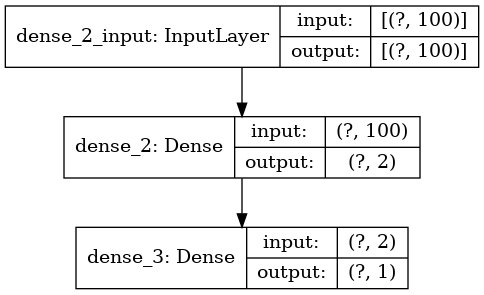

In [3]:
f_name   = 'data17_13TeV_EGAM2_probes_lhmedium_EGAM7_vetolhvloose.model_v1.electronLoose.et2_eta0.json'
w_name   = 'data17_13TeV_EGAM2_probes_lhmedium_EGAM7_vetolhvloose.model_v1.electronLoose.et2_eta0.h5'

m_ringer = load_ringer_model(os.path.join(model_path, f_name), os.path.join(model_path, w_name))
tf.keras.utils.plot_model(m_ringer, to_file=os.path.join(proc_path, 'ringer_model_mlp.png'), show_shapes=True)

In [4]:
m_ringer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 205
Trainable params: 205
Non-trainable params: 0
_________________________________________________________________


In [5]:
def decide_ringer(r_df, r_model):

    rings_cols = ['L2Calo_ring_%i' %(iring) for iring in range(100)]
    rings = r_df[rings_cols].values
    rings /= np.abs(rings.sum(axis=1))[:, None] # normalization step
    output = r_model.predict(rings)[:,0]

    # thresholds for tight selection
    decide_threshold = [-0.006501296841225447, #slope
                        -1.4896478184400082] #offset
                        
    thr_ = r_df.avgmu.values*decide_threshold[0] + decide_threshold[1]

    # add the NN output to dataframe
    r_df['ringer_model_output'] = output

    output[output > thr_]  = 1    
    output[output <= thr_] = 0
    
    # add the decision to dataframe
    r_df['ringer_model_decision'] = output

In [6]:
et, eta   = 2, 0
file_name = 'data17_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM2.bkg.VProbes_EGAM7.GRL_v97_et%i_eta%i.npz'
f         = dict(np.load(os.path.join(data17_path, file_name %(et, eta))))
trn_data  = pd.DataFrame(data=f['data'], columns=f['features'])
# add target info
trn_data['target'] = f['target']

trn_data.head()

,avgmu,L2Calo_ring_0,L2Calo_ring_1,L2Calo_ring_2,L2Calo_ring_3,L2Calo_ring_4,L2Calo_ring_5,L2Calo_ring_6,L2Calo_ring_7,L2Calo_ring_8,...,deltaE,T0HLTElectronT2CaloTight,T0HLTElectronT2CaloMedium,T0HLTElectronT2CaloLoose,T0HLTElectronT2CaloVLoose,HLT__isLHTight,HLT__isLHMedium,HLT__isLHLoose,HLT__isLHVLoose,target
0,47.509998,1056.258057,322.188080,332.912659,-280.741852,21.125513,-131.229263,-38.171936,-160.671906,1016.838379,...,5007.001953,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1
1,47.450001,870.888245,776.392395,-90.251289,10.248786,568.193481,-63.480675,-62.772644,152.331909,1623.090454,...,6382.289062,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,35.820339,554.257324,91.470505,-232.490112,-146.808426,-1.804339,-119.220062,-381.634277,49.214310,987.953186,...,5909.175781,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,35.820339,704.402771,407.674438,688.304016,376.865265,-3.415975,247.710114,22.180048,171.543243,2058.773682,...,7770.158203,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,34.590000,969.125366,545.412903,-202.046585,-72.834450,-324.668976,237.151871,-154.877655,-175.607117,1428.432373,...,3861.644531,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [7]:
file_name = 'data18_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM2.bkg.VProbes_EGAM7.GRL_v97_et%i_eta%i.npz'
f         = dict(np.load(os.path.join(data18_path, file_name %(et, eta))))
tst_data  = pd.DataFrame(data=f['data'], columns=f['features'])
# add target info
tst_data['target'] = f['target']

tst_data.head()

,avgmu,L2Calo_ring_0,L2Calo_ring_1,L2Calo_ring_2,L2Calo_ring_3,L2Calo_ring_4,L2Calo_ring_5,L2Calo_ring_6,L2Calo_ring_7,L2Calo_ring_8,...,deltaE,T0HLTElectronT2CaloTight,T0HLTElectronT2CaloMedium,T0HLTElectronT2CaloLoose,T0HLTElectronT2CaloVLoose,HLT__isLHTight,HLT__isLHMedium,HLT__isLHLoose,HLT__isLHVLoose,target
0,27.469999,387.098663,-89.680824,-255.651337,-287.546844,110.434181,-58.393150,-442.061249,-153.431427,1928.999146,...,4718.567871,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,27.430000,256.859467,11.232599,79.235909,307.981049,294.465027,156.160309,105.975983,-86.119347,1715.609009,...,10039.893555,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,27.044315,722.743591,597.676758,217.899933,-407.054474,216.712311,109.028130,626.465759,-36.638813,2316.582764,...,5776.427246,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,27.044315,722.743591,597.676758,217.899933,-407.054474,216.712311,109.028130,626.465759,-36.638813,2316.582764,...,7019.850098,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,26.740000,346.583282,6.475327,239.444763,142.588318,106.107285,43.513710,-145.464417,-149.455276,2121.921143,...,8373.983398,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [8]:
trn_data['mu_type']     = trn_data.avgmu.apply(lambda x: 'low_mu' if x <40 else 'high_mu')
trn_data['mu_type_idx'] = trn_data.avgmu.apply(lambda x: 0 if x <40 else 1)

tst_data['mu_type']     = tst_data.avgmu.apply(lambda x: 'low_mu' if x <40 else 'high_mu')
tst_data['mu_type_idx'] = tst_data.avgmu.apply(lambda x: 0 if x <40 else 1)

In [9]:
decide_ringer(trn_data, m_ringer)
decide_ringer(tst_data, m_ringer)
del m_ringer

In [10]:
trn_data.groupby(['mu_type', 'target'])['ringer_model_decision'].value_counts()

mu_type  target  ringer_model_decision
high_mu  0       0.0                       49210
                 1.0                        5799
         1       1.0                        2738
                 0.0                          28
low_mu   0       0.0                      156696
                 1.0                       14858
         1       1.0                       19015
                 0.0                         210
Name: ringer_model_decision, dtype: int64

In [11]:
tst_data.groupby(['mu_type', 'target'])['ringer_model_decision'].value_counts()

mu_type  target  ringer_model_decision
high_mu  0       0.0                       64707
                 1.0                        7865
         1       1.0                        1463
                 0.0                          15
low_mu   0       0.0                      146003
                 1.0                       15328
         1       1.0                       21461
                 0.0                         233
Name: ringer_model_decision, dtype: int64

In [12]:
def prepare_data(dataframe):

    ring_cols = ['L2Calo_ring_%i' %(iring) for iring in range(100)]

    data_dict = {}

    data_dict[0]  = (dataframe[dataframe.mu_type == 'low_mu'][ring_cols].values,
                     dataframe[dataframe.mu_type == 'low_mu']['target'].values,
                     dataframe[dataframe.mu_type == 'low_mu']['ringer_model_decision'].values,
                     dataframe[dataframe.mu_type == 'low_mu']['ringer_model_output'].values)
    
    data_dict[1] = (dataframe[dataframe.mu_type == 'high_mu'][ring_cols].values,
                    dataframe[dataframe.mu_type == 'high_mu']['target'].values,
                    dataframe[dataframe.mu_type == 'high_mu']['ringer_model_decision'].values,
                    dataframe[dataframe.mu_type == 'high_mu']['ringer_model_output'].values)
   
    
    return data_dict


def bala_preparation(dataframe):
    
    ring_cols = ['L2Calo_ring_%i' %(iring) for iring in range(100)]

    input_samples = np.array([])
    for task in ['low_mu', 'high_mu']:
        if input_samples.size == 0:
            input_samples = np.expand_dims(dataframe[ring_cols].values, axis=0)
            target_ = np.expand_dims(dataframe.target.values, axis=0)
        else:
            input_samples = np.append(input_samples,np.expand_dims(dataframe[ring_cols].values, axis=0),axis=0)
            target_ = np.append(target_,np.expand_dims(dataframe.target.values, axis=0),axis=0)
    return input_samples, target_

In [13]:
n_dim  = trn_data[['L2Calo_ring_%i' %(iring) for iring in range(100)]].shape[1]
m_data = prepare_data(trn_data)#bala_preparation(trn_data)

In [14]:
del trn_data

In [15]:
taskName = [0, 1]
n_splits = 10
# creates a KFold dict for each task 
kfold_dict = {}
kf = StratifiedKFold(n_splits=n_splits)
for t in taskName:
    print(t)
    r=0
    temp_dict = {}
    #for train_index, test_index in kf.split(m_data[0][t], m_data[1][t]):
    for train_index, test_index in kf.split(m_data[t][0], m_data[t][1]):
        temp_dict[r] = {'train_index':train_index,'test_index':test_index}
        print(train_index.shape,test_index.shape)
        r+=1
    kfold_dict[t] = temp_dict.copy()

0
(171701,) (19078,)
(171701,) (19078,)
(171701,) (19078,)
(171701,) (19078,)
(171701,) (19078,)
(171701,) (19078,)
(171701,) (19078,)
(171701,) (19078,)
(171701,) (19078,)
(171702,) (19077,)
1
(51997,) (5778,)
(51997,) (5778,)
(51997,) (5778,)
(51997,) (5778,)
(51997,) (5778,)
(51998,) (5777,)
(51998,) (5777,)
(51998,) (5777,)
(51998,) (5777,)
(51998,) (5777,)


In [16]:
import gc
gc.collect()

2437

In [17]:
tst_data.head()

,avgmu,L2Calo_ring_0,L2Calo_ring_1,L2Calo_ring_2,L2Calo_ring_3,L2Calo_ring_4,L2Calo_ring_5,L2Calo_ring_6,L2Calo_ring_7,L2Calo_ring_8,...,T0HLTElectronT2CaloVLoose,HLT__isLHTight,HLT__isLHMedium,HLT__isLHLoose,HLT__isLHVLoose,target,mu_type,mu_type_idx,ringer_model_output,ringer_model_decision
0,27.469999,387.098663,-89.680824,-255.651337,-287.546844,110.434181,-58.393150,-442.061249,-153.431427,1928.999146,...,1.0,1.0,1.0,1.0,1.0,1,low_mu,0,4.786071,1.0
1,27.430000,256.859467,11.232599,79.235909,307.981049,294.465027,156.160309,105.975983,-86.119347,1715.609009,...,1.0,1.0,1.0,1.0,1.0,1,low_mu,0,1.556949,1.0
2,27.044315,722.743591,597.676758,217.899933,-407.054474,216.712311,109.028130,626.465759,-36.638813,2316.582764,...,1.0,1.0,1.0,1.0,1.0,1,low_mu,0,0.912933,1.0
3,27.044315,722.743591,597.676758,217.899933,-407.054474,216.712311,109.028130,626.465759,-36.638813,2316.582764,...,1.0,1.0,1.0,1.0,1.0,1,low_mu,0,0.912933,1.0
4,26.740000,346.583282,6.475327,239.444763,142.588318,106.107285,43.513710,-145.464417,-149.455276,2121.921143,...,1.0,1.0,1.0,1.0,1.0,1,low_mu,0,2.404812,1.0


In [18]:
data18 = {
    0 : (tst_data[tst_data.mu_type_idx == 0].target.values,
         tst_data[tst_data.mu_type_idx == 0][['L2Calo_ring_%i' %(iring) for iring in range(100)]].values,
         tst_data[tst_data.mu_type_idx == 0]['ringer_model_output'].values
        ),

    1 : (tst_data[tst_data.mu_type_idx == 1].target.values,
         tst_data[tst_data.mu_type_idx == 1][['L2Calo_ring_%i' %(iring) for iring in range(100)]].values,
         tst_data[tst_data.mu_type_idx == 1]['ringer_model_output'].values
        ),
}

In [19]:
n_splits = 10

# set up ELLA
T = len(taskName)
d = n_dim
k = d # same latent as features

#kf = KFold(n_splits=n_splits)
kfold_nr=0

m_results = {
    'fold'               : [],
    'task'               : [],
    # MLP    
    'auc_ringer_val'     : [],
    'sp_ringer_val'      : [],
    'pd_ringer_val'      : [],
    'fa_ringer_val'      : [],
    'auc_ringer_tst'     : [],
    'sp_ringer_tst'      : [],
    'pd_ringer_tst'      : [],
    'fa_ringer_tst'      : [],
    #'mean_sp_ringer_val' : [],
    #'mean_pd_ringer_val' : [],
    #'mean_fa_ringer_val' : [],
    # ELLA
    'auc_ella_val'       : [],
    'sp_ella_val'        : [],
    'pd_ella_val'        : [],
    'fa_ella_val'        : [],
    'auc_ella_tst'       : [],
    'sp_ella_tst'        : [],
    'pd_ella_tst'        : [],
    'fa_ella_tst'        : [],
    #'mean_sp_ella_val'   : [],
    #'mean_pd_ella_val'   : [],
    #'mean_fa_ella_val'   : [],
}
for n_fold in range(n_splits):
    print('|-> Begin process on fold: %i' %(n_fold+1))
    fold_name = 'fold_%i' %(n_fold+1) 
    #m_results[fold_name] = {}
    # create ELLA
    model = ELLA(d,k,LogisticRegression,mu=1,lam=10**-5)  # LinearRegression, Ridge, or LogisticRegression
    
    Xs_train  = {}
    Xs_test   = {}
    Ys_train  = {}
    Ys_test   = {}
    r_dec_trn = {}
    r_out_trn = {}
    r_dec_tst = {}
    r_out_tst = {}
    # train ELLA
    for t in taskName:
        print('|--> Training on task: %i' %t)
        train_index, test_index = kfold_dict[t][n_fold]['train_index'], kfold_dict[t][n_fold]['test_index']
        
        Xs_train[t], Ys_train[t] = m_data[t][0][train_index,:], m_data[t][1][train_index]
        Xs_test[t] , Ys_test[t]  = m_data[t][0][test_index,:] , m_data[t][1][test_index]
        
        # ringer decision 
        r_dec_trn[t], r_dec_tst[t] = m_data[t][2][train_index], m_data[t][2][test_index]
        r_out_trn[t], r_out_tst[t] = m_data[t][3][train_index], m_data[t][3][test_index]
        
        model.fit(Xs_train[t], Ys_train[t], t)
    print('|---> Finish training... ')
    # test ELLA 
    # test on each task
    print('|----> Testing... ')
    for itask in taskName:
        #m_results[fold_name][itask] = {}

        
        m_results['fold'].append(fold_name)
        m_results['task'].append(itask)

        r_val_sp, r_val_pd, r_val_fa = sp_index(Ys_test[itask], r_out_tst[itask])
        m_results['sp_ringer_val'].append(r_val_sp)
        m_results['pd_ringer_val'].append(r_val_pd)
        m_results['fa_ringer_val'].append(r_val_fa)
        #m_results[fold_name]['sp_ringer_val']  = r_val_sp
        #m_results[fold_name]['pd_ringer_val']  = r_val_pd
        #m_results[fold_name]['fa_ringer_val']  = r_val_fa

        #m_results[fold_name]['auc_ringer_val'] = roc_auc_score(Ys_test[itask], r_out_tst[itask])
        m_results['auc_ringer_val'].append(roc_auc_score(Ys_test[itask], r_out_tst[itask]))

        #m_results[fold_name][itask]['auc_ella_val']   = roc_auc_score(Ys_test[itask], model.predict_logprobs(Xs_test[itask], itask))
        m_results['auc_ella_val'].append(roc_auc_score(Ys_test[itask], model.predict_logprobs(Xs_test[itask], itask)))

        e_val_sp, e_val_pd, e_val_fa = sp_index(Ys_test[itask], model.predict_logprobs(Xs_test[itask], itask))
        m_results['sp_ella_val'].append(e_val_sp)
        m_results['pd_ella_val'].append(e_val_pd)
        m_results['fa_ella_val'].append(e_val_fa)
        #m_results[fold_name]['sp_ella_val']    = e_val_sp
        #m_results[fold_name]['pd_ella_val']    = e_val_pd
        #m_results[fold_name]['fa_ella_val']    = e_val_fa

        # test on data 18
        y_tst, x_tst, r_tst = data18[itask]

        r_tst_sp, r_tst_pd, r_tst_fa = sp_index(y_tst, r_tst)
        m_results['sp_ringer_tst'].append(r_tst_sp)
        m_results['pd_ringer_tst'].append(r_tst_pd)
        m_results['fa_ringer_tst'].append(r_tst_fa)
        #m_results[fold_name]['sp_ringer_tst']  = r_tst_sp
        #m_results[fold_name]['pd_ringer_tst']  = r_tst_pd
        #m_results[fold_name]['fa_ringer_tst']  = r_tst_fa

        #m_results[fold_name]['auc_ringer_tst'] = roc_auc_score(y_tst, r_tst)
        m_results['auc_ringer_tst'].append(roc_auc_score(y_tst, r_tst))

        #m_results[fold_name][itask]['auc_ella_tst']   = roc_auc_score(y_tst, model.predict_logprobs(x_tst, itask))
        m_results['auc_ella_tst'].append(roc_auc_score(y_tst, model.predict_logprobs(x_tst, itask)))

        e_tst_sp, e_tst_pd, e_tst_fa = sp_index(y_tst, model.predict_logprobs(x_tst, itask))
        m_results['sp_ella_tst'].append(e_tst_sp)
        m_results['pd_ella_tst'].append(e_tst_pd)
        m_results['fa_ella_tst'].append(e_tst_fa)
        #m_results[fold_name]['sp_ella_tst']    = e_tst_sp
        #m_results[fold_name]['pd_ella_tst']    = e_tst_pd
        #m_results[fold_name]['fa_ella_tst']    = e_tst_fa

    # getting mean results

    r_val_sp, r_val_pd, r_val_fa = np.mean(np.array([sp_index(Ys_test[t], r_out_tst[t]) for t in taskName]), axis=0)
    #m_results[fold_name]['mean_sp_ringer_val']  = r_val_sp
    #m_results[fold_name]['mean_pd_ringer_val']  = r_val_pd
    #m_results[fold_name]['mean_fa_ringer_val']  = r_val_fa

    #m_results[fold_name]['mean_auc_ringer_val'] = 
    mean_auc_ringer_val = np.mean([roc_auc_score(Ys_test[t], r_out_tst[t]) for t in taskName], axis=0)

    #m_results[fold_name]['mean_auc_ella_val']   = np.mean([roc_auc_score(Ys_test[t], 
    #                                                      model.predict_logprobs(Xs_test[t], t)) for t in taskName], axis=0)
    mean_auc_ella_val   = np.mean([roc_auc_score(Ys_test[t], model.predict_logprobs(Xs_test[t], t)) for t in taskName], axis=0)

    e_val_sp, e_val_pd, e_val_fa = np.mean(np.array([sp_index(Ys_test[t], model.predict_logprobs(Xs_test[t], t)) for t in taskName]), axis=0)
    #m_results[fold_name]['mean_sp_ella_val']    = e_val_sp
    #m_results[fold_name]['mean_pd_ella_val']    = e_val_pd
    #m_results[fold_name]['mean_fa_ella_val']    = e_val_fa

    # test on data18

    r_tst_sp, r_tst_pd, r_tst_fa = np.mean(np.array([sp_index(data18[t][0], data18[t][2]) for t in taskName]), axis=0)
    #m_results[fold_name]['mean_sp_ringer_tst']  = r_tst_sp
    #m_results[fold_name]['mean_pd_ringer_tst']  = r_tst_pd
    #m_results[fold_name]['mean_fa_ringer_tst']  = r_tst_fa

    #m_results[fold_name]['mean_auc_ringer_tst'] = 
    mean_auc_ringer_tst = np.mean([roc_auc_score(data18[t][0], data18[t][2]) for t in taskName], axis=0)

    #m_results[fold_name]['mean_auc_ella_tst']   = np.mean([roc_auc_score(data18[t][0], 
    #                                                      model.predict_logprobs(data18[t][1], t)) for t in taskName], axis=0)
    mean_auc_ella_tst   = np.mean([roc_auc_score(data18[t][0], model.predict_logprobs(data18[t][1], t)) for t in taskName], axis=0)

    e_tst_sp, e_tst_pd, e_tst_fa = np.mean(np.array([sp_index(data18[t][0], model.predict_logprobs(data18[t][1], t)) for t in taskName]), axis=0)
    #m_results[fold_name]['mean_sp_ella_tst']    = e_tst_sp
    #m_results[fold_name]['mean_pd_ella_tst']    = e_tst_pd
    #m_results[fold_name]['mean_fa_ella_tst']    = e_tst_fa

    print('~.~'*10)

    print('Report: \n')

    print('Validation: \n')
    print('Ringer ELLA \n |-> SP: %1.2f %% | PD: %1.2f %% | FA: %1.2f %% | AUC: %1.2f \n' %(e_val_sp*100, 100*e_tst_pd, 
                                                                                   e_val_fa*100, mean_auc_ella_val))
    print('Ringer MLP \n |-> SP: %1.2f %% | PD: %1.2f %% | FA: %1.2f %% | AUC: %1.2f \n' %(r_val_sp*100, 100*r_tst_pd, 
                                                                                   r_val_fa*100, mean_auc_ella_val))
    print('Test: \n')
    print('Ringer ELLA \n |-> SP: %1.2f %% | PD: %1.2f %% | FA: %1.2f %% | AUC: %1.2f \n' %(e_tst_sp*100, 100*e_tst_pd, 
                                                                                   e_tst_fa*100, mean_auc_ella_tst))
    print('Ringer MLP \n |-> SP: %1.2f %% | PD: %1.2f %% | FA: %1.2f %% | AUC: %1.2f \n' %(r_tst_sp*100, 100*r_tst_pd, 
                                                                                   r_tst_fa*100, mean_auc_ella_tst))
    print('~.~'*10)
        
    kfold_nr+=1
    del model, Xs_train, Xs_test, Ys_train, Ys_test, r_dec_trn, r_out_trn, r_dec_tst, r_out_tst
    # call garbage collector
    gc.collect()
# save the final results
#joblib.dump(m_results, os.path.join(proc_path, 'ELLA_results.jbl'))

|-> Begin process on fold: 1
|--> Training on task: 0
|--> Training on task: 1
|---> Finish training... 
|----> Testing... 
~.~~.~~.~~.~~.~~.~~.~~.~~.~~.~
Report: 

Validation: 

Ringer ELLA 
 |-> SP: 96.12 % | PD: 96.96 % | FA: 4.08 % | AUC: 0.99 

Ringer MLP 
 |-> SP: 96.75 % | PD: 97.38 % | FA: 4.83 % | AUC: 0.99 

Test: 

Ringer ELLA 
 |-> SP: 95.47 % | PD: 96.96 % | FA: 6.02 % | AUC: 0.99 

Ringer MLP 
 |-> SP: 95.87 % | PD: 97.38 % | FA: 5.63 % | AUC: 0.99 

~.~~.~~.~~.~~.~~.~~.~~.~~.~~.~
|-> Begin process on fold: 2
|--> Training on task: 0
|--> Training on task: 1
|---> Finish training... 
|----> Testing... 
~.~~.~~.~~.~~.~~.~~.~~.~~.~~.~
Report: 

Validation: 

Ringer ELLA 
 |-> SP: 95.69 % | PD: 96.84 % | FA: 5.55 % | AUC: 0.99 

Ringer MLP 
 |-> SP: 96.34 % | PD: 97.38 % | FA: 4.85 % | AUC: 0.99 

Test: 

Ringer ELLA 
 |-> SP: 95.41 % | PD: 96.84 % | FA: 6.00 % | AUC: 0.99 

Ringer MLP 
 |-> SP: 95.87 % | PD: 97.38 % | FA: 5.63 % | AUC: 0.99 

~.~~.~~.~~.~~.~~.~~.~~.~~.~~.~


In [20]:
m_df = pd.DataFrame.from_dict(m_results)
m_df.head()

,fold,task,auc_ringer_val,sp_ringer_val,pd_ringer_val,fa_ringer_val,auc_ringer_tst,sp_ringer_tst,pd_ringer_tst,fa_ringer_tst,auc_ella_val,sp_ella_val,pd_ella_val,fa_ella_val,auc_ella_tst,sp_ella_tst,pd_ella_tst,fa_ella_tst
0,fold_1,0,0.991843,0.967361,0.981279,0.046459,0.990187,0.960564,0.971974,0.050778,0.991624,0.965476,0.973479,0.042495,0.990149,0.957989,0.964322,0.048323
1,fold_1,1,0.991127,0.967611,0.985560,0.050173,0.987213,0.956788,0.975643,0.061883,0.989951,0.956988,0.953069,0.039084,0.986521,0.951325,0.974966,0.072025
2,fold_2,0,0.990545,0.963231,0.968799,0.042320,0.990187,0.960564,0.971974,0.050778,0.990362,0.961310,0.967759,0.045118,0.989886,0.957001,0.966581,0.052532
3,fold_2,1,0.990114,0.963529,0.981949,0.054717,0.987213,0.956788,0.975643,0.061883,0.989587,0.952567,0.971119,0.065806,0.986592,0.951248,0.970230,0.067547
4,fold_3,0,0.991792,0.964426,0.972959,0.044069,0.990187,0.960564,0.971974,0.050778,0.991646,0.960633,0.971399,0.050073,0.989960,0.957288,0.966120,0.051503


In [21]:
len(m_df)

20

In [22]:
m_df.to_csv(os.path.join(proc_path, 'ringer_ella_results.csv'), index=False)

In [23]:
analysis_cols = ['auc_ringer_val', 'sp_ringer_val',	'pd_ringer_val', 'fa_ringer_val', 
                 #'auc_ringer_tst', 'sp_ringer_tst', 'pd_ringer_tst', 'fa_ringer_tst', 
                 'auc_ella_val', 'sp_ella_val', 'pd_ella_val', 'fa_ella_val',] 
                 #'auc_ella_tst', 'sp_ella_tst', 'pd_ella_tst',	'fa_ella_tst']


In [24]:
np.round(m_df.groupby('task')[analysis_cols].agg(['mean', 'std']).T*100, 2)

task                     0      1
auc_ringer_val mean  99.17  99.04
               std    0.08   0.12
sp_ringer_val  mean  96.48  96.36
               std    0.17   0.43
pd_ringer_val  mean  97.09  97.11
               std    0.59   1.28
fa_ringer_val  mean   4.13   4.37
               std    0.42   0.96
auc_ella_val   mean  99.14  99.02
               std    0.08   0.10
sp_ella_val    mean  96.17  95.86
               std    0.19   0.46
pd_ella_val    mean  96.72  96.82
               std    0.45   1.08
fa_ella_val    mean   4.37   5.10
               std    0.37   1.12

In [25]:
test_cols = ['task', 'auc_ringer_tst', 'sp_ringer_tst', 'pd_ringer_tst', 'fa_ringer_tst',
             'auc_ella_tst', 'sp_ella_tst', 'pd_ella_tst',	'fa_ella_tst']
test_df = m_df[test_cols].copy().drop_duplicates(subset =['auc_ringer_tst'])

In [26]:
np.round(test_df*100,2)

,task,auc_ringer_tst,sp_ringer_tst,pd_ringer_tst,fa_ringer_tst,auc_ella_tst,sp_ella_tst,pd_ella_tst,fa_ella_tst
0,0,99.02,96.06,97.20,5.08,99.01,95.80,96.43,4.83
1,100,98.72,95.68,97.56,6.19,98.65,95.13,97.50,7.20


In [27]:
task_label = [r'Low $\langle \mu \rangle$', r'High $\langle \mu \rangle$']

dict_names = {
    'auc_ringer_tst' : r'$AUC_{MLP}$ Test',  
    'sp_ringer_tst'  : r'$Max SP_{MLP}$ Test',
    'pd_ringer_tst'  : r'$PD_{MLP}$ Test',
    'fa_ringer_tst'  : r'$FA_{MLP}$ Test',
    'auc_ella_tst'   : r'$AUC_{ELLA}$ Test',
    'sp_ella_tst'    : r'$Max SP_{ELLA}$ Test',
    'pd_ella_tst'    : r'$PD_{ELLA}$ Test',
    'fa_ella_tst'    : r'$FA_{ELLa}$ Test',

    # validation
    'auc_ringer_val' : r'$AUC_{MLP}$ Validation',  
    'sp_ringer_val'  : r'$Max SP_{MLP}$ Validation',
    'pd_ringer_val'  : r'$PD_{MLP}$ Validation',
    'fa_ringer_val'  : r'$FA_{MLP}$ Validation',
    'auc_ella_val'   : r'$AUC_{ELLA}$ Validation',
    'sp_ella_val'    : r'$Max SP_{ELLA}$ Validation',
    'pd_ella_val'    : r'$PD_{ELLA}$ Validation',
    'fa_ella_val'    : r'$FA_{ELLa}$ Validation',

    'task'           : 'Task',
    'fold'           : 'Fold'
}
# using as simple function in order to make easier plot all need measures
def create_cool_catplot(df, key, kind, mapped_key, output_name, axis=None):
    # create the box plot. 
    # rename the columns names.
    # map the model idx into real # neurons.

    sns.catplot(data=(df
                        .replace({'task' : {i :  n for i, n in enumerate(task_label)}})
                        .rename({'task'  : 'Task',
                                key : mapped_key},
                        axis=1)), x='Task',
                        y=mapped_key, kind=kind, sharey=False,
                        ax=axis)

    plt.tight_layout()
    plt.savefig(os.path.join(proc_path, '%s_plot_%s.png' %(kind, output_name)), dpi=300)
    #plt.show()
    #plt.close()

In [28]:
m_df.head()

,fold,task,auc_ringer_val,sp_ringer_val,pd_ringer_val,fa_ringer_val,auc_ringer_tst,sp_ringer_tst,pd_ringer_tst,fa_ringer_tst,auc_ella_val,sp_ella_val,pd_ella_val,fa_ella_val,auc_ella_tst,sp_ella_tst,pd_ella_tst,fa_ella_tst
0,fold_1,0,0.991843,0.967361,0.981279,0.046459,0.990187,0.960564,0.971974,0.050778,0.991624,0.965476,0.973479,0.042495,0.990149,0.957989,0.964322,0.048323
1,fold_1,1,0.991127,0.967611,0.985560,0.050173,0.987213,0.956788,0.975643,0.061883,0.989951,0.956988,0.953069,0.039084,0.986521,0.951325,0.974966,0.072025
2,fold_2,0,0.990545,0.963231,0.968799,0.042320,0.990187,0.960564,0.971974,0.050778,0.990362,0.961310,0.967759,0.045118,0.989886,0.957001,0.966581,0.052532
3,fold_2,1,0.990114,0.963529,0.981949,0.054717,0.987213,0.956788,0.975643,0.061883,0.989587,0.952567,0.971119,0.065806,0.986592,0.951248,0.970230,0.067547
4,fold_3,0,0.991792,0.964426,0.972959,0.044069,0.990187,0.960564,0.971974,0.050778,0.991646,0.960633,0.971399,0.050073,0.989960,0.957288,0.966120,0.051503


In [29]:
pair_list = [('auc_ringer_val', 'auc_ella_val'),
             ('sp_ringer_val', 'sp_ella_val'),
             ('pd_ringer_val', 'pd_ella_val'),
             ('fa_ringer_val', 'fa_ella_val'),
             ]

auc_ringer_val
auc_ella_val


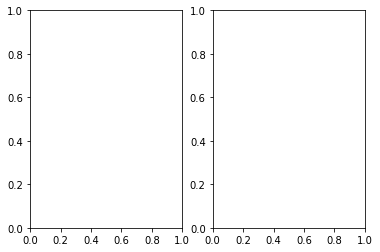

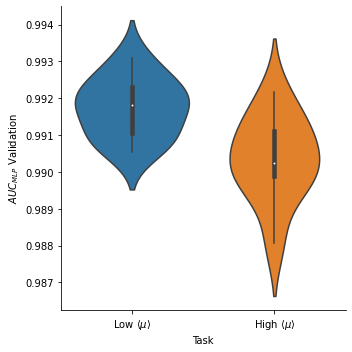

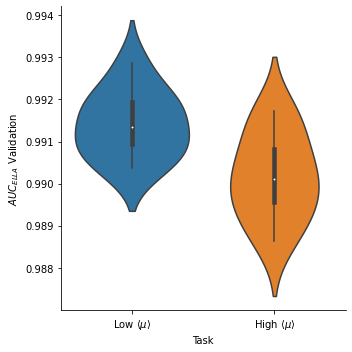

sp_ringer_val
sp_ella_val


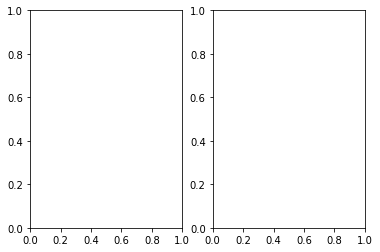

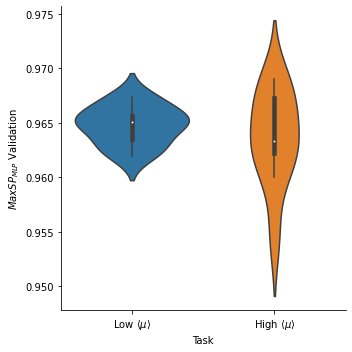

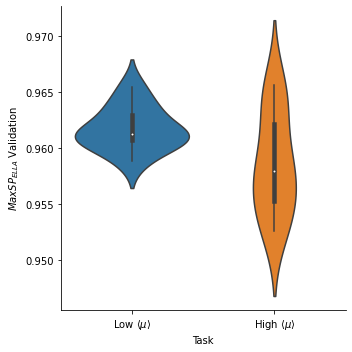

pd_ringer_val
pd_ella_val


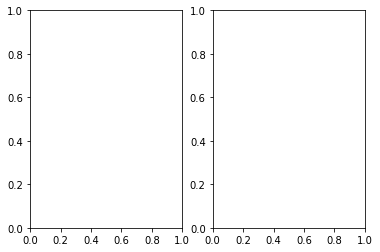

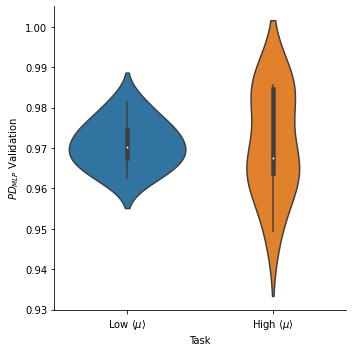

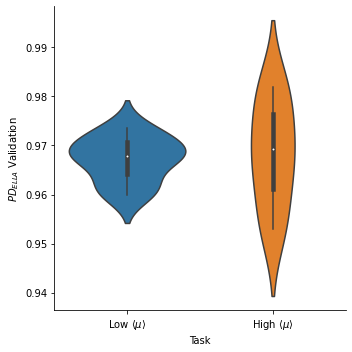

fa_ringer_val
fa_ella_val


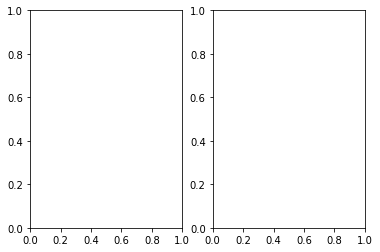

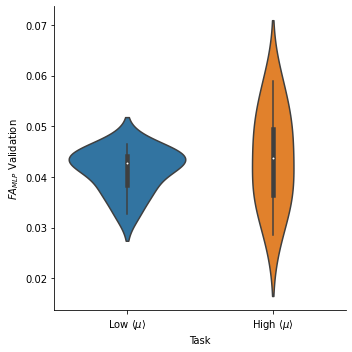

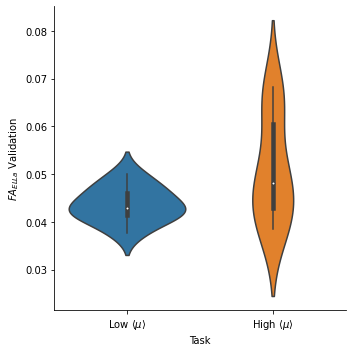

In [30]:
for comp_pair in pair_list: 
    #plt.figure(figsize=(10, 5))
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
    for measure in comp_pair:
        print(measure)
        create_cool_catplot(m_df, key=measure, kind='violin', mapped_key=dict_names[measure], output_name=measure)
    plt.show()